<a href="https://colab.research.google.com/github/olfabre/amsProjetSemestre2/blob/main/10_05_mod%C3%A8le_avec_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Entraînement sur le dataset de mots de passe...
 39s (1000 100%) 2.0625]


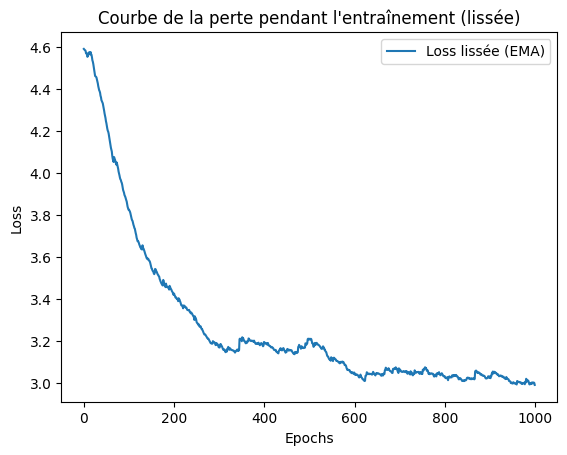

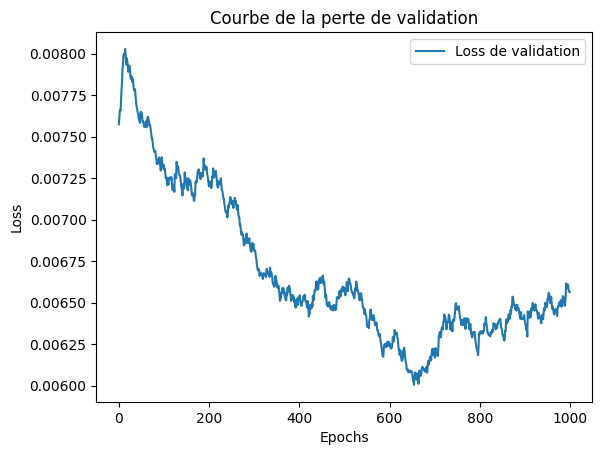

Génération de mots de passe après entraînement :
Ob777
Ininab
G22
l0
Ovatetrdabaren
inc442
M3
BHAb8
qecin
hand


In [2]:
!pip install unidecode

import unidecode
import string
import random
import torch
import torch.nn as nn
from torch.autograd import Variable
import time, math
import matplotlib.pyplot as plt
from os import path, makedirs

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

all_characters = string.ascii_letters + string.digits + string.punctuation
end_char = '&'
selected = string.ascii_letters + string.digits + end_char
n_characters = len(all_characters)
n_characters_selected = len(selected)

chunk_len = 12

hidden_size = 256
n_layers = 2
lr = 0.005
n_epochs = 1000

train_file = unidecode.unidecode(open("sample_data/train2.txt").read())
train_file_len = len(train_file)
val_file = unidecode.unidecode(open("sample_data/validation2.txt").read())
val_file_len = len(val_file)

def random_chunk(file, file_len):
  start_index = random.randint(0, file_len - chunk_len - 1)
  end_index = start_index + chunk_len + 1
  return file[start_index:end_index]

def char_tensor(string):
  tensor = torch.zeros(len(string)).long()
  for c in range(len(string)):
    if string[c] not in selected:
      continue
    tensor[c] = selected.index(string[c])
  return tensor.to(device)

def random_training_set(file, file_len):
  chunk = random_chunk(file, file_len)
  inp = char_tensor(chunk[:-1])
  target = char_tensor(chunk[1:])
  return inp, target

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.bidirectional = True
        self.num_directions = 2 if self.bidirectional else 1

        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, bidirectional=self.bidirectional)
        self.decoder = nn.Linear(hidden_size * self.num_directions, output_size)

    def forward(self, input, hidden):
        embedded = self.encoder(input.view(1, -1))
        output, hidden = self.gru(embedded.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))  # Concaténation des deux directions
        return output, hidden

    def init_hidden(self):
        return torch.zeros(self.n_layers * self.num_directions, 1, self.hidden_size, device=device)



def train(inp, target):
  hidden = decoder.init_hidden()
  decoder.zero_grad()
  loss = 0
  seq_len = inp.size(0) # Récupérer la longueur du batch actuel
  for c in range(seq_len):
    output, hidden = decoder(inp[c], hidden)
    loss += criterion(output, target[c].unsqueeze(0))
  loss.backward()
  optimizer.step()
  train_losses.append(loss.item() / seq_len)
  return loss.item() / seq_len


def evaluate(prime_str='A', predict_len=25, temperature=0.8):
  if predict_len is None:
    predict_len = random.randint(5, 12)

  hidden = decoder.init_hidden()
  prime_input = char_tensor(prime_str)
  predicted = prime_str

  for p in range(len(prime_str) - 1):
    _, hidden = decoder(prime_input[p], hidden)
  inp = prime_input[-1]

  for _ in range(predict_len):
    output, hidden = decoder(inp, hidden)
    output_dist = torch.softmax(output.data.view(-1) / temperature, dim=0)
    top_i = torch.multinomial(output_dist[:len(selected)], 1)[0]
    predicted_char = selected[top_i]

    if predicted_char == '&':
      break

    predicted += predicted_char
    inp = torch.tensor([selected.index(predicted_char)]).to(device)

  return predicted


def time_since(since):
  s = time.time() - since
  m = math.floor(s / 60)
  s -= m * 60
  return '%dm %ds' % (m, s)

def exponential_moving_average(values, alpha=0.01):
  ema = []
  avg = values[0] # Initialisation
  for value in values:
    avg = alpha * value + (1 - alpha) * avg
    ema.append(avg)
  return ema

def evaluate_loss(n_samples=1000):
  total_loss = 0
  for _ in range(n_samples):
    inp, target = random_training_set(val_file, val_file_len)
    hidden = decoder.init_hidden()
    loss = 0
  for c in range(inp.size(0)):
    output, hidden = decoder(inp[c], hidden)
  loss += criterion(output, target[c].unsqueeze(0))
  total_loss += loss.item() / inp.size(0)
  return total_loss / n_samples

decoder = RNN(n_characters, hidden_size, n_characters, n_layers).to(device)
optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

train_losses = []
eval_losses = []
print("Entraînement sur le dataset de mots de passe...")

start = time.time()
for epoch in range(1, n_epochs + 1):
  loss = train(*random_training_set(train_file, train_file_len))
  with torch.no_grad():
    eval_loss = evaluate_loss(n_samples=50)
    eval_losses.append(eval_loss)
  if epoch % 1000 == 0:
    print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))

smoothed_train_losses = exponential_moving_average(train_losses, alpha=0.01)
smoothed_eval_losses = exponential_moving_average(eval_losses, alpha=0.01)

plt.plot(smoothed_train_losses, label='Loss lissée (EMA)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Courbe de la perte pendant l\'entraînement (lissée)')
plt.legend()
plt.show()

plt.plot(smoothed_eval_losses, label='Loss de validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Courbe de la perte de validation')
plt.legend()
plt.show()

# save

if not path.exists("models"):
  makedirs("models")
torch.save(decoder, f"models/password_rnn_55.pt")

print("Génération de mots de passe après entraînement :")
for _ in range(10):
  print(evaluate(prime_str=random.choice(selected), temperature=0.7))

✅ Modèle chargé avec succès !

📊 Résultats de la validation sur 500 échantillons :
   - Validation Loss : 3.7555
   - Validation Accuracy : 3.67%


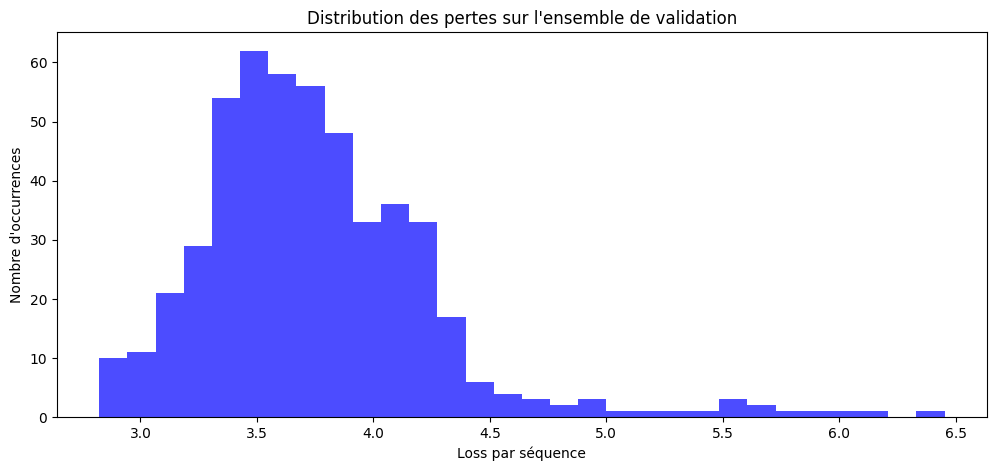

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
5005 mots de passe générés.
5006 mots de passe générés.
5007 mots de passe générés.
5008 mots de passe générés.
5009 mots de passe générés.
5010 mots de passe générés.
5011 mots de passe générés.
5012 mots de passe générés.
5013 mots de passe générés.
5014 mots de passe générés.
5015 mots de passe générés.
5016 mots de passe générés.
5017 mots de passe générés.
5018 mots de passe générés.
5019 mots de passe générés.
5020 mots de passe générés.
5021 mots de passe générés.
5022 mots de passe générés.
5023 mots de passe générés.
5024 mots de passe générés.
5025 mots de passe générés.
5026 mots de passe générés.
5027 mots de passe générés.
5028 mots de passe générés.
5029 mots de passe générés.
5030 mots de passe générés.
5031 mots de passe générés.
5032 mots de passe générés.
5033 mots de passe générés.
5034 mots de passe générés.
5035 mots de passe générés.
5036 mots de passe générés.
5037 mots de passe générés

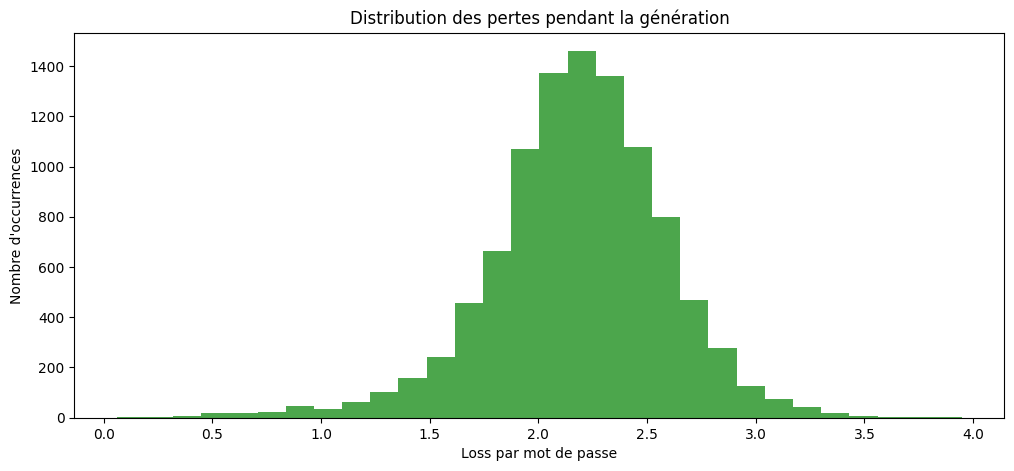

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
912 mots de passe générés.
913 mots de passe générés.
914 mots de passe générés.
915 mots de passe générés.
916 mots de passe générés.
917 mots de passe générés.
918 mots de passe générés.
919 mots de passe générés.
920 mots de passe générés.
921 mots de passe générés.
922 mots de passe générés.
923 mots de passe générés.
924 mots de passe générés.
925 mots de passe générés.
926 mots de passe générés.
927 mots de passe générés.
928 mots de passe générés.
929 mots de passe générés.
930 mots de passe générés.
931 mots de passe générés.
932 mots de passe générés.
933 mots de passe générés.
934 mots de passe générés.
935 mots de passe générés.
936 mots de passe générés.
937 mots de passe générés.
938 mots de passe générés.
939 mots de passe générés.
940 mots de passe générés.
941 mots de passe générés.
942 mots de passe générés.
943 mots de passe générés.
944 mots de passe générés.
945 mots de passe générés.
946 

In [ ]:
!pip install unidecode

import unidecode
import string
import random
import torch
import torch.nn as nn
from torch.autograd import Variable
import time, math
import matplotlib.pyplot as plt
from os import path, makedirs

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.bidirectional = True
        self.num_directions = 2 if self.bidirectional else 1

        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, bidirectional=self.bidirectional)
        self.decoder = nn.Linear(hidden_size * self.num_directions, output_size)

    def forward(self, input, hidden):
        embedded = self.encoder(input.view(1, -1))
        output, hidden = self.gru(embedded.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))  # Concaténation des deux directions
        return output, hidden

    def init_hidden(self):
        return torch.zeros(self.n_layers * self.num_directions, 1, self.hidden_size, device=device)

# Charger le modèle entraîné
if path.exists("models/password_rnn_55.pt"):
    decoder = torch.load("models/password_rnn_55.pt", weights_only=False).to(device)
    decoder.eval()  # Mettre le modèle en mode évaluation
    print("✅ Modèle chargé avec succès !")
else:
    print("❌ Erreur : modèle introuvable.")
    exit()

# Charger les données de validation
try:
    val_file = unidecode.unidecode(open("sample_data/test2.txt").read())
    val_file_len = len(val_file)
except FileNotFoundError:
    print("❌ Erreur : Le fichier test2.txt est introuvable.")
    exit()

# Paramètres globaux
chunk_len = 12
all_characters = string.ascii_letters + string.digits + string.punctuation
end_char = '&'
selected = string.ascii_letters + string.digits + end_char
n_characters = len(all_characters)
n_characters_selected = len(selected)
hidden_size = 256
n_layers = 2
lr = 0.005
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Fonction pour transformer un texte en tenseur de caractères
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        if string[c] not in selected:
            continue
        tensor[c] = selected.index(string[c])
    return tensor.to(device)

# Fonction pour obtenir un batch de validation
def validation_set():
    start_index = random.randint(0, val_file_len - chunk_len - 1)
    end_index = start_index + chunk_len + 1
    chunk = val_file[start_index:end_index]
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

# Fonction d'évaluation
def evaluate_model(num_samples=100):
    total_loss = 0
    correct = 0
    total = 0
    all_losses = []

    with torch.no_grad():
        for _ in range(num_samples):
            inp, target = validation_set()
            hidden = decoder.init_hidden()
            loss = 0
            seq_len = inp.size(0)

            for c in range(seq_len):
                output, hidden = decoder(inp[c].unsqueeze(0), hidden)
                loss += criterion(output, target[c].unsqueeze(0))

                # Calcul de l'accuracy
                pred = output.argmax(dim=1)
                correct += (pred == target[c]).sum().item()
                total += 1

            loss = loss.item() / seq_len
            total_loss += loss
            all_losses.append(loss)

    avg_loss = total_loss / num_samples
    accuracy = correct / total * 100

    return avg_loss, accuracy, all_losses

# Fonction pour générer un mot de passe
def evaluate(prime_str='A', predict_len=25, temperature=0.8):
    if predict_len is None:
        predict_len = random.randint(5, 12)

    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]

    for _ in range(predict_len):
        output, hidden = decoder(inp, hidden)
        output_dist = torch.softmax(output.data.view(-1) / temperature, dim=0)
        top_i = torch.multinomial(output_dist[:len(selected)], 1)[0]
        predicted_char = selected[top_i]

        if predicted_char == '&':
            break

        predicted += predicted_char
        inp = torch.tensor([selected.index(predicted_char)]).to(device)

    return predicted

# Exécuter l'évaluation
criterion = nn.CrossEntropyLoss()
val_loss, val_accuracy, all_losses = evaluate_model(num_samples=500)

print(f"\n📊 Résultats de la validation sur 500 échantillons :")
print(f"   - Validation Loss : {val_loss:.4f}")
print(f"   - Validation Accuracy : {val_accuracy:.2f}%")

# Affichage graphique des pertes
plt.figure(figsize=(12, 5))
plt.hist(all_losses, bins=30, color="blue", alpha=0.7)
plt.xlabel("Loss par séquence")
plt.ylabel("Nombre d'occurrences")
plt.title("Distribution des pertes sur l'ensemble de validation")
plt.show()

# Générer et sauvegarder des mots de passe après l'évaluation
def generate_passwords(n=100, min_len=6, max_len=11, temperature=0.7):
    passwords = []
    total_loss = 0
    correct = 0
    total = 0
    all_losses = []

    for i in range(n):
        while True:
            prime_char = random.choice(selected)
            hidden = decoder.init_hidden()
            prime_input = char_tensor(prime_char)
            predicted = prime_char
            loss = 0

            # Initialisation
            inp = prime_input[0]
            password_target = ""

            for _ in range(max_len):  # Générer jusqu'à max_len
                output, hidden = decoder(inp, hidden)
                output_dist = torch.softmax(output.data.view(-1) / temperature, dim=0)
                top_i = torch.multinomial(output_dist[:len(selected)], 1)[0]
                predicted_char = selected[top_i]

                if predicted_char == '&':
                    break

                predicted += predicted_char
                password_target += predicted_char

                # Préparer la prochaine entrée
                target_idx = torch.tensor([selected.index(predicted_char)]).to(device)

                loss += criterion(output, target_idx)
                pred_idx = output.argmax(dim=1)
                correct += (pred_idx == target_idx).sum().item()
                total += 1

                inp = target_idx  # La prédiction devient l’entrée suivante

            # Vérifie la longueur
            if min_len <= len(predicted) <= max_len:
                passwords.append(predicted)
                total_loss += loss.item() / len(predicted)
                all_losses.append(loss.item() / len(predicted))
                break

        if i % 1 == 0:
            print(f"{i + 1} mots de passe générés.")

    avg_loss = total_loss / n
    accuracy = correct / total * 100
    print(f"\n📊 Évaluation pendant génération :")
    print(f"   - Moyenne Loss : {avg_loss:.4f}")
    print(f"   - Accuracy     : {accuracy:.2f}%")

    # Affichage histogramme
    plt.figure(figsize=(12, 5))
    plt.hist(all_losses, bins=30, color="green", alpha=0.7)
    plt.xlabel("Loss par mot de passe")
    plt.ylabel("Nombre d'occurrences")
    plt.title("Distribution des pertes pendant la génération")
    plt.show()

    output_path = f"passwords_{n}.txt"
    with open(output_path, "w") as f:
        for pwd in passwords:
            f.write(pwd + "\n")

    print(f"✅ {n} mots de passe sauvegardés dans : {output_path}")


generated_passwords = generate_passwords(n=10000)
generated_passwords = generate_passwords(n=100000)
generated_passwords = generate_passwords(n=1000000)


